In [1]:
#resnet from https://keras.io/examples/cifar10_resnet/
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
tf.VERSION

'1.14.0'

In [3]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [4]:



def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-3
    if epoch > 180:
        lr *= 0.5e-1
    elif epoch > 160:
        lr *= 1e-1
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [5]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=.9,lr=1e-3),
              metrics=['categorical_crossentropy','accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
#checkpoint = ModelCheckpoint(filepath=filepath,
#                             monitor='val_acc',
#                             verbose=1,
#                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                               cooldown=0,
#                               patience=5,
#                               min_lr=0.5e-6)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
"""def scheduler(epoch):
  if epoch >=250:
    return 1e-4
  else:
    return 1e-3

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)"""
history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=250,
              validation_data=(x_test, y_test),
              shuffle=True)
#history=model.fit(x_train, y_train,
#              batch_size=batch_size,
#              epochs=250,
#              validation_data=(x_test, y_test),
#              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 26s 526us/sample - loss: 2.7075 - categorical_crossentropy: 2.0967 - acc: 0.2322 - val_loss: 2.5951 - val_categorical_crossentropy: 1.9848 - val_acc: 0.2685
Epoch 2/250
50000/50000 [==============================] - 20s 402us/sample - loss: 2.5194 - categorical_crossentropy: 1.9096 - acc: 0.3088 - val_loss: 2.4636 - val_categorical_crossentropy: 1.8543 - val_acc: 0.3186
Epoch 3/250
50000/50000 [==============================] - 20s 399us/sample - loss: 2.4285 - categorical_crossentropy: 1.8197 - acc: 0.3397 - val_loss: 2.3856 - val_categorical_crossentropy: 1.7773 - val_acc: 0.3549
Epoch 4/250
50000/50000 [==============================] - 20s 398us/sample - loss: 2.3601 - categorical_crossentropy: 1.7522 - acc: 0.3645 - val_loss: 2.3247 - val_categorical_crossentropy: 1.7174 - val_acc: 0.3712
Epoch 5/250
50000/50000 [==============================] - 20s 399us/sample - loss: 2.

In [11]:
!ls

loss_increase_lr.ipynb	model1e_3


In [10]:
model.save('model1e_3')

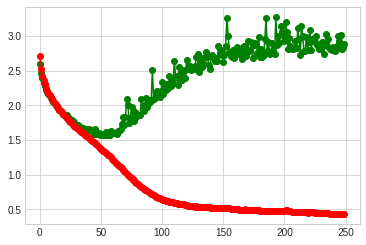

In [12]:
plt.plot(range(0,250), history.history['val_loss'], '-ok',c='g');
plt.plot(range(0,250), history.history['loss'], '-ok',c='r');

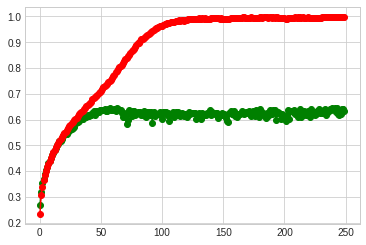

In [17]:
plt.plot(range(0,250), history.history['val_acc'], '-ok',c='g');
plt.plot(range(0,250), history.history['acc'], '-ok',c='r');

In [18]:
pred=model.predict(x_train)
max_probs=pred[np.arange(len(pred)),np.argmax(pred,axis=-1)]
print(max_probs.shape)

(50000,)


In [19]:
print(max_probs)

[0.99990225 0.9999993  0.99999774 ... 0.99999726 1.         0.9999981 ]


(array([0.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00,
        5.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00,
        5.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00, 7.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 5.0000e+00, 6.0000e+00,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 7.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 6.0000e+00, 4.0000e+00,
        2.0000e+00, 6.0000e+00, 2.0000e+00, 6.0000e+00, 5.0000e+00,
        8.0000e+00, 4.0000e+00, 6.0000e+00, 9.0000e+00, 3.0000e+00,
        6.0000e+00, 5.0000e+00, 4.0000e+00, 5.0000e+00, 1.5000e+01,
        1.3000e+01, 8.0000e+00, 6.0000e+00, 1.2000e+01, 8.0000e+00,
        1.1000e+01, 1.5000e+01, 1.3000e+01, 1.2000e+01, 1.3000e+01,
        1.7000e+01, 1.4000e+01, 1.5000e+01, 1.5000e+01, 1.9000e+01,
        2.2000e+01, 1.8000e+01, 1.8000e+01, 2.5000e+01, 2.2000e+01,
        2.2000e+01, 1.8000e+01, 2.8000e+01, 1.90

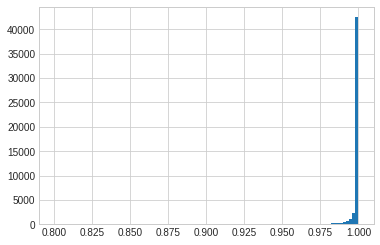

In [21]:
plt.hist(max_probs,bins=100,range=(.8,1))

In [22]:
pred_test=model.predict(x_test)
max_probs_test=pred_test[np.arange(len(pred_test)),np.argmax(pred_test,axis=-1)]
print(max_probs_test.shape)

(10000,)


(array([  44.,   54.,   40.,   45.,   58.,   43.,   40.,   44.,   49.,
          47.,   50.,   43.,   54.,   56.,   52.,   46.,   57.,   55.,
          66.,   59.,   52.,   58.,   58.,   42.,   65.,   71.,   60.,
          68.,   70.,   56.,   70.,   64.,   59.,   69.,   67.,   81.,
          85.,   85.,   91.,   86.,  103.,  104.,  144.,  157.,  185.,
         202.,  243.,  309.,  520., 5432.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ], dtype=float32),
 <a list of 50 Patch objects>)

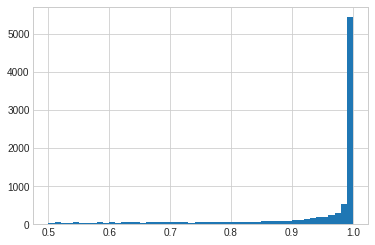

In [26]:
plt.hist(max_probs_test,bins=50,range=(0.5,1))

In [27]:
x_test.shape

(10000, 32, 32, 3)

In [29]:
x_rand=np.random.normal(0,1,(10000,32,32,3))

In [31]:
x_rand.shape
print(x_rand[:5])

[[[[ 1.09517696e-01  1.56485466e+00  8.66964608e-01]
   [-1.16017337e+00  2.33505885e-01  9.99357227e-01]
   [-1.97035792e-01 -8.93394987e-01 -5.58100751e-01]
   ...
   [ 1.06889197e+00 -5.23206474e-01  1.01043813e+00]
   [-6.95714044e-01 -1.16289326e+00  1.56653783e-01]
   [ 2.29737405e+00 -2.03422157e+00 -3.20804863e-01]]

  [[-4.13051627e-01  9.21423678e-01  2.31958067e-01]
   [-4.69828105e-01 -5.12926089e-01 -4.58648824e-01]
   [ 1.60591508e-02  1.94651361e+00  2.02450637e-01]
   ...
   [ 8.61536951e-02 -1.38220446e+00  1.47374557e+00]
   [-4.74167025e-01  6.43053087e-01 -2.99909922e-01]
   [ 2.28132810e-01 -6.53317226e-01 -1.57362222e+00]]

  [[-5.43797153e-01 -1.53745695e-01 -1.75267024e+00]
   [ 5.19216964e-01  7.30805090e-01 -1.72227321e-02]
   [-1.33736283e+00  9.26355267e-01  1.55609315e+00]
   ...
   [ 1.11204167e+00  2.71224328e-01  1.66712931e+00]
   [-1.43882385e+00 -5.05887390e-01  6.05147454e-01]
   [ 2.96142753e-01 -1.10255777e-01  4.00254892e-01]]

  ...

  [[-8.27619

In [32]:
pred_rand=model.predict(x_rand)
max_probs_rand=pred_rand[np.arange(len(pred_rand)),np.argmax(pred_rand,axis=-1)]
print(max_probs_rand.shape)

(10000,)


(array([  20.,   22.,   23.,   30.,   31.,   30.,   29.,   39.,   33.,
          36.,   32.,   28.,   24.,   32.,   22.,   34.,   31.,   28.,
          39.,   42.,   36.,   33.,   35.,   31.,   37.,   27.,   50.,
          38.,   41.,   47.,   38.,   46.,   56.,   47.,   66.,   58.,
          61.,   64.,   62.,   70.,   82.,   84.,  105.,  113.,  135.,
         171.,  208.,  272.,  496., 6775.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ], dtype=float32),
 <a list of 50 Patch objects>)

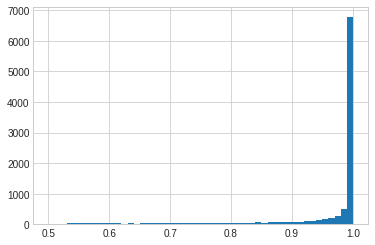

In [34]:
plt.hist(max_probs_rand,bins=50,range=(0.5,1))

In [36]:
print(max_probs_rand[:20])

[0.87567484 0.99998665 0.9992663  0.999383   0.9999826  0.99939597
 0.9989543  0.9999993  1.         1.         0.9999993  0.9992525
 1.         1.         0.8734039  0.99461585 0.60104483 1.
 0.95941436 0.9991117 ]


In [37]:
#ask how best to measure if these 2 histograms are similar. maybe just normalize and k-l?
#first train new net on normal data for 10 epochs
#then train new net on random data for 50 epochs
#if good, try like 250 maybe

In [38]:
if version == 2:
    model2 = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model2 = resnet_v1(input_shape=input_shape, depth=depth)

model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=.9,lr=1e-3),
              metrics=['categorical_crossentropy','accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 16)   64          conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 32, 32, 16)   0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [44]:
pred_rand2=model2.predict(x_rand)
max_probs_rand2=pred_rand2[np.arange(len(pred_rand2)),np.argmax(pred_rand2,axis=-1)]
print(max_probs_rand2.shape)

(10000,)


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10000.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <a list of 50 Patch objects>)

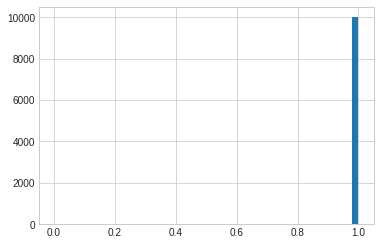

In [45]:
plt.hist(max_probs_rand2,bins=50,range=(0,1))

In [41]:
print(max_probs_rand2[:20])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [46]:
history2=model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 23s 469us/sample - loss: 2.7257 - categorical_crossentropy: 2.1161 - acc: 0.2256 - val_loss: 2.5977 - val_categorical_crossentropy: 1.9885 - val_acc: 0.2791
Epoch 2/20
50000/50000 [==============================] - 20s 400us/sample - loss: 2.5071 - categorical_crossentropy: 1.8984 - acc: 0.3175 - val_loss: 2.4337 - val_categorical_crossentropy: 1.8256 - val_acc: 0.3458
Epoch 3/20
50000/50000 [==============================] - 20s 401us/sample - loss: 2.3973 - categorical_crossentropy: 1.7896 - acc: 0.3570 - val_loss: 2.3395 - val_categorical_crossentropy: 1.7323 - val_acc: 0.3740
Epoch 4/20
50000/50000 [==============================] - 20s 400us/sample - loss: 2.3186 - categorical_crossentropy: 1.7119 - acc: 0.3844 - val_loss: 2.2793 - val_categorical_crossentropy: 1.6730 - val_acc: 0.3931
Epoch 5/20
50000/50000 [==============================] - 20s 400us/sample - loss: 2.2653 

In [47]:
pred_rand2=model2.predict(x_rand)
max_probs_rand2=pred_rand2[np.arange(len(pred_rand2)),np.argmax(pred_rand2,axis=-1)]
print(max_probs_rand2.shape)

(10000,)


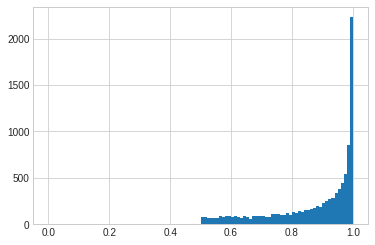

In [49]:
plt.hist(max_probs_rand2,bins=100,range=(0,1));

In [62]:
#print out hist every 10 epochs
if version == 2:
    model2 = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model2 = resnet_v1(input_shape=input_shape, depth=depth)

model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=.9,lr=1e-3),
              metrics=['categorical_crossentropy','accuracy'])
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 32, 32, 16)   64          conv2d_186[0][0]                 
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 32, 32, 16)   0           batch_normalization_168[0][0]    
____________________________________________________________________________________________

In [63]:
max_probs_arr_train=[]
max_probs_arr_test=[]
for i in range(15):
    history2=model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)
    #print('epoch '+str(i))
    pred_train=model2.predict(x_train)
    max_probs_train=pred_train[np.arange(len(pred_train)),np.argmax(pred_train,axis=-1)]
    max_probs_arr_train.append(max_probs_train)
    pred_test=model2.predict(x_test)
    max_probs_test=pred_test[np.arange(len(pred_test)),np.argmax(pred_test,axis=-1)]
    max_probs_arr_test.append(max_probs_test)
    #plt.hist(max_probs_rand2,bins=100,range=(0,1));

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 528us/sample - loss: 2.7088 - categorical_crossentropy: 2.0950 - acc: 0.2338 - val_loss: 2.5773 - val_categorical_crossentropy: 1.9639 - val_acc: 0.2774
Epoch 2/10
50000/50000 [==============================] - 21s 415us/sample - loss: 2.4811 - categorical_crossentropy: 1.8682 - acc: 0.3184 - val_loss: 2.4173 - val_categorical_crossentropy: 1.8049 - val_acc: 0.3365
Epoch 3/10
50000/50000 [==============================] - 21s 416us/sample - loss: 2.3838 - categorical_crossentropy: 1.7719 - acc: 0.3500 - val_loss: 2.3396 - val_categorical_crossentropy: 1.7282 - val_acc: 0.3669
Epoch 4/10
50000/50000 [==============================] - 21s 423us/sample - loss: 2.3183 - categorical_crossentropy: 1.7074 - acc: 0.3751 - val_loss: 2.2813 - val_categorical_crossentropy: 1.6709 - val_acc: 0.3866
Epoch 5/10
50000/50000 [==============================] - 21s 427us/sample - loss: 2.2693 

0


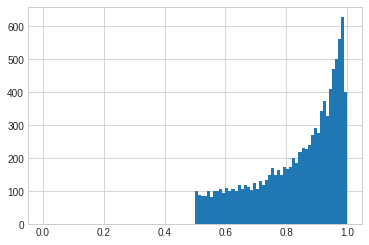

1


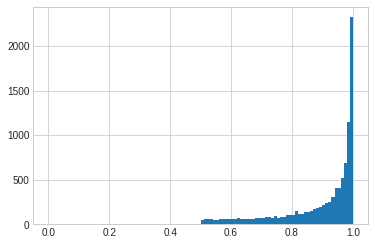

2


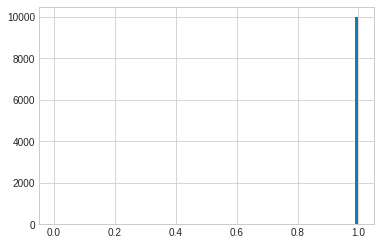

3


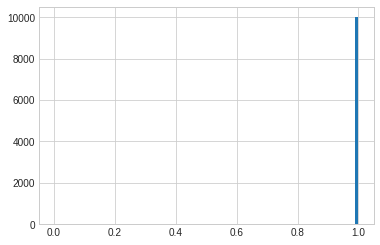

4


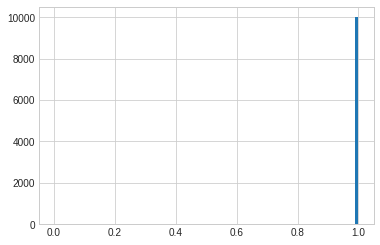

5


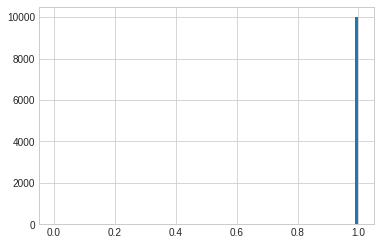

6


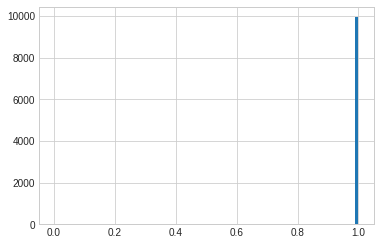

7


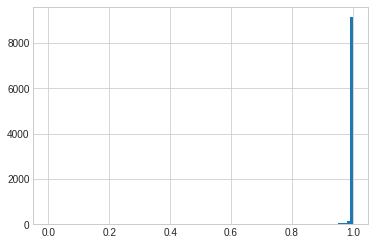

8


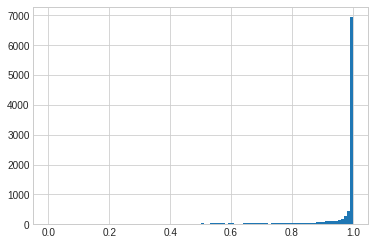

9


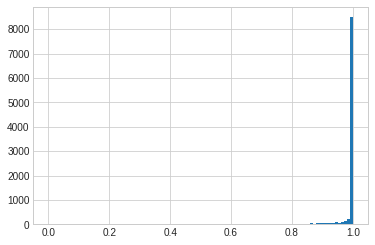

10


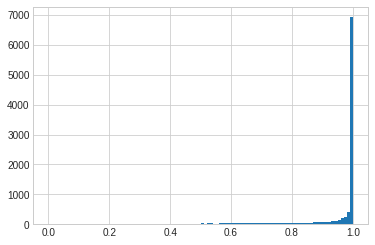

11


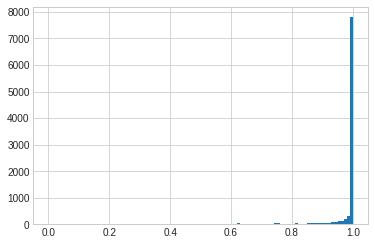

12


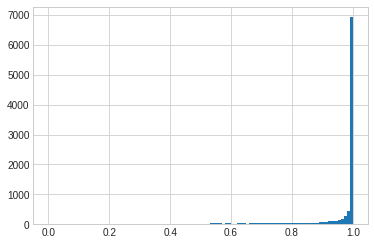

13


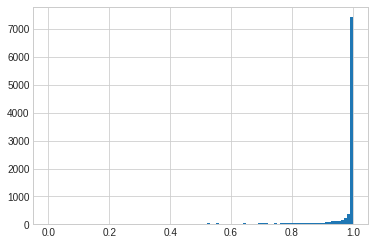

14


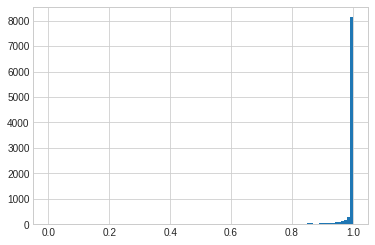

In [58]:
#also do above with actual data
for i in range(15):
    print(i)
    plt.hist(max_probs_arr[i],bins=100,range=(0,1));
    plt.show()

0


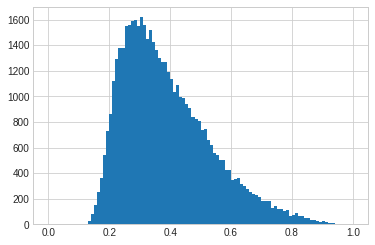

1


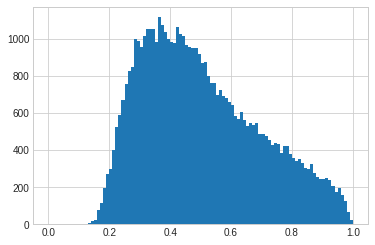

2


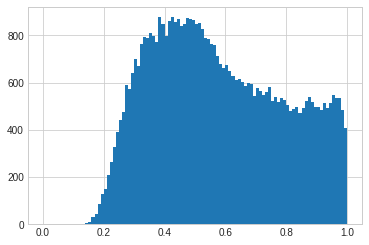

3


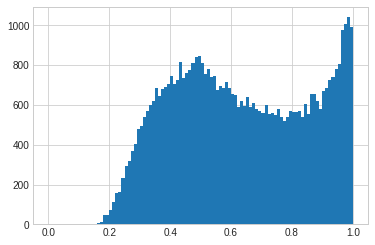

4


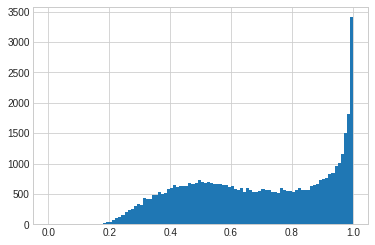

5


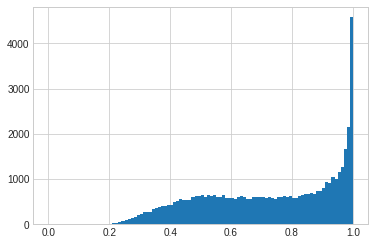

6


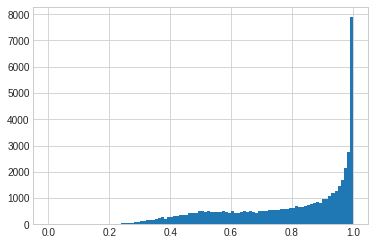

7


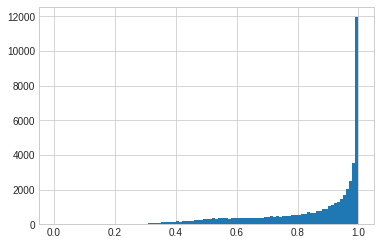

8


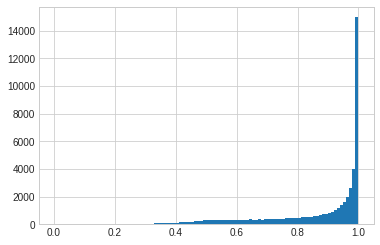

9


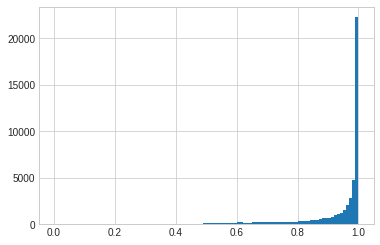

10


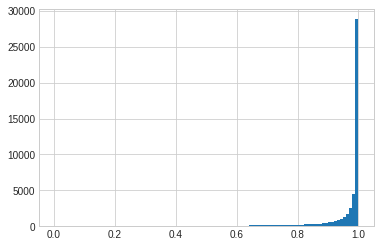

11


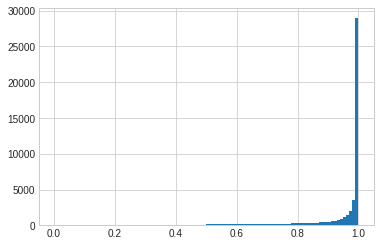

12


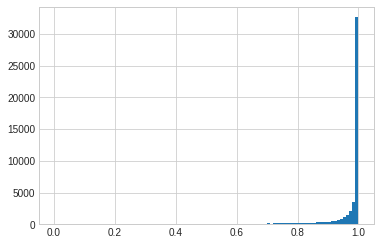

13


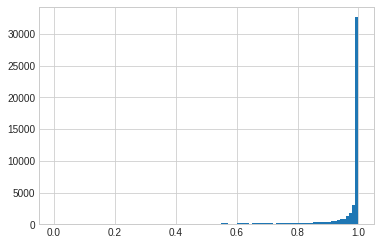

14


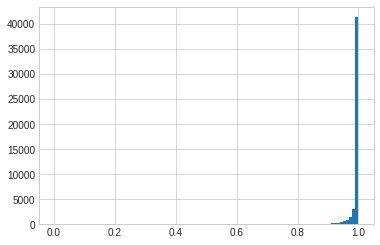

In [64]:
for i in range(15):
    print(i)
    plt.hist(max_probs_arr_train[i],bins=100,range=(0,1));
    plt.show()

0


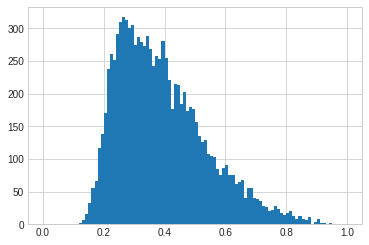

1


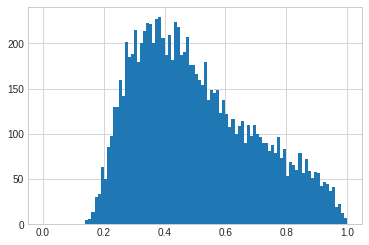

2


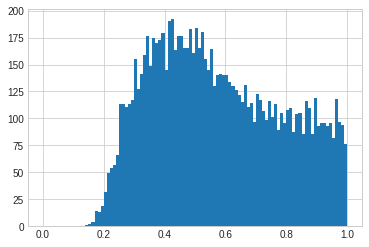

3


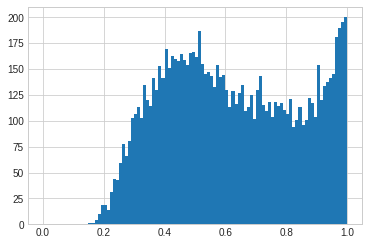

4


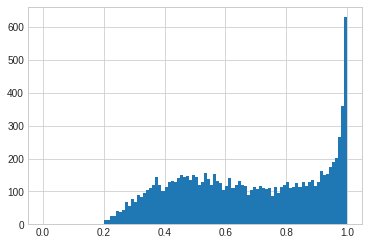

5


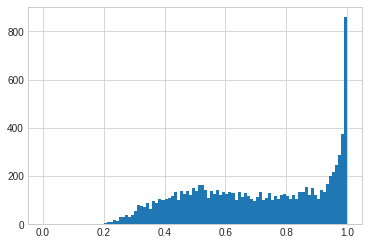

6


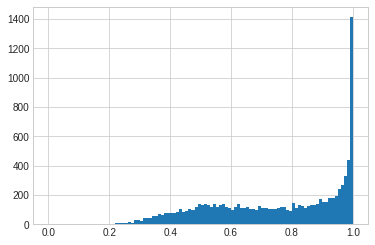

7


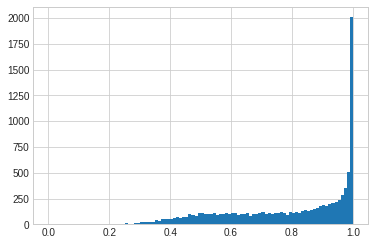

8


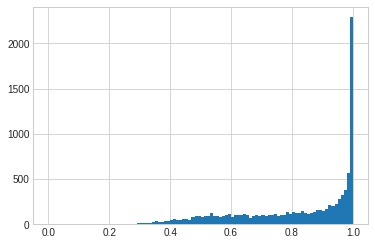

9


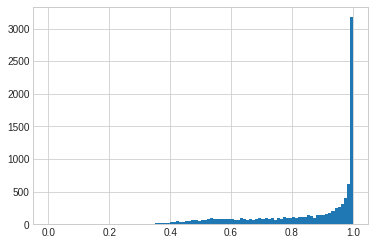

10


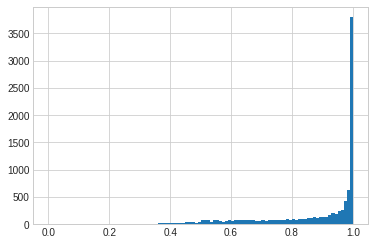

11


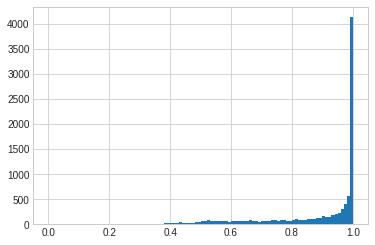

12


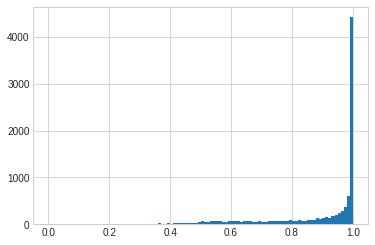

13


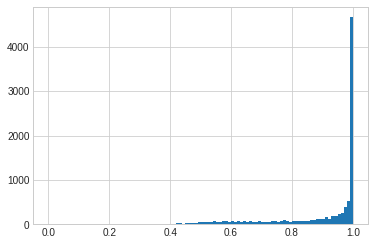

14


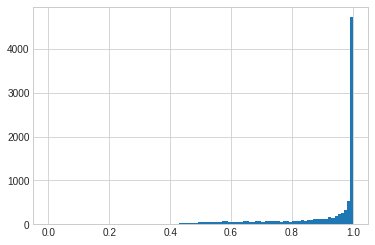

In [65]:
for i in range(15):
    print(i)
    plt.hist(max_probs_arr_test[i],bins=100,range=(0,1));
    plt.show()

In [69]:
print(x_rand[0][0])

[[ 0.1095177   1.56485466  0.86696461]
 [-1.16017337  0.23350588  0.99935723]
 [-0.19703579 -0.89339499 -0.55810075]
 [-0.77746101  1.53325224  0.03042566]
 [-0.25788091 -0.44489058 -0.1149531 ]
 [ 2.54503251  0.07235279  1.51366551]
 [-0.41352681 -0.19003042 -0.14458576]
 [ 2.37116815 -0.47991624 -0.28993877]
 [ 0.9958151  -1.61562785  0.59581913]
 [-0.85008124  0.76202861  0.31040693]
 [-0.8533318   0.44683617 -0.91024055]
 [ 0.02393105  1.13235516 -1.32239575]
 [ 2.25882797  0.33039773  1.49815016]
 [-1.07148244  0.11032187 -0.62777993]
 [-0.3247835  -1.82994575  0.67407962]
 [ 0.40970969  1.18589884  0.56970764]
 [-0.13636022  0.52685132  2.07502885]
 [ 1.15133467 -0.64934685 -1.42717834]
 [-0.31341484  1.04436353 -1.55146768]
 [-2.23566964  0.64129598  0.57732037]
 [-1.16027043  0.0754196  -0.6935676 ]
 [-1.37846671  0.08850029  0.47366631]
 [ 0.41523568  0.25488527 -0.16561748]
 [ 0.14153975  0.0969178  -0.83123066]
 [ 0.28542396 -0.14373868  1.51477584]
 [-2.1144411   0.15700047

In [68]:
print(x_train[0][0])

[[-0.28121656 -0.2904184  -0.272762  ]
 [-0.3417282  -0.35075825 -0.3406073 ]
 [-0.31784582 -0.3460663  -0.35130537]
 [-0.24929157 -0.3242303  -0.3563872 ]
 [-0.13406172 -0.2518796  -0.31870103]
 [-0.05432341 -0.18374744 -0.27757806]
 [ 0.02206933 -0.12268624 -0.23199037]
 [ 0.04356331 -0.11271378 -0.21382466]
 [ 0.05692065 -0.08735809 -0.18045619]
 [ 0.05516279 -0.07699654 -0.16585878]
 [-0.01660705 -0.14487293 -0.22945985]
 [-0.04080406 -0.16114703 -0.23396876]
 [ 0.02501225 -0.0991011  -0.1757606 ]
 [ 0.03280276 -0.11083832 -0.19533703]
 [ 0.00535029 -0.13814858 -0.22266653]
 [-0.02593207 -0.16931179 -0.2538093 ]
 [ 0.00575948 -0.13370737 -0.22189823]
 [-0.00590163 -0.13358232 -0.2335603 ]
 [-0.04506794 -0.16884515 -0.28069678]
 [ 0.01417804 -0.1057376  -0.22539553]
 [ 0.01525122 -0.10868725 -0.2361283 ]
 [-0.00768566 -0.13576707 -0.25952908]
 [ 0.00466084 -0.13529578 -0.2396498 ]
 [ 0.01753843 -0.12274209 -0.22718188]
 [ 0.07040161 -0.07430843 -0.17893204]
 [ 0.11526155 -0.02976137

In [70]:
x_rand=np.random.uniform(0,1,(10000,32,32,3))

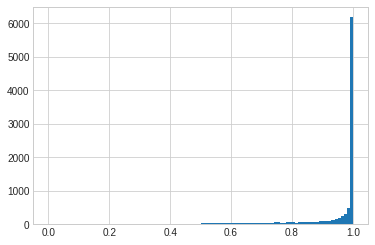

In [71]:
pred_rand2=model2.predict(x_rand)
max_probs_rand2=pred_rand2[np.arange(len(pred_rand2)),np.argmax(pred_rand2,axis=-1)]
plt.hist(max_probs_rand2,bins=100,range=(0,1));

In [72]:
if version == 2:
    model3 = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model3 = resnet_v1(input_shape=input_shape, depth=depth)

model3.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=.9,lr=1e-3),
              metrics=['categorical_crossentropy','accuracy'])
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_217 (Conv2D)             (None, 32, 32, 16)   448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_196 (BatchN (None, 32, 32, 16)   64          conv2d_217[0][0]                 
__________________________________________________________________________________________________
activation_196 (Activation)     (None, 32, 32, 16)   0           batch_normalization_196[0][0]    
____________________________________________________________________________________________